In [115]:
import os
import pandas as pd
import numpy as np
import librosa
import noisereduce as nr
import soundfile as sf
os.getcwd()

'/content'

In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
csv_path = '/content/drive/MyDrive/extracted_audios/audio_index.csv'
df = pd.read_csv(csv_path)
df.head()

,speaker_id,speaker_folder,subfolder_id,audio_id,path
0,Steltek,Steltek-20090509-twd,wav,a0527,/content/drive/MyDrive/extracted_audios/Stelte...
1,Steltek,Steltek-20090509-twd,wav,a0529,/content/drive/MyDrive/extracted_audios/Stelte...
2,Steltek,Steltek-20090509-twd,wav,a0526,/content/drive/MyDrive/extracted_audios/Stelte...
3,Steltek,Steltek-20090509-twd,wav,a0525,/content/drive/MyDrive/extracted_audios/Stelte...
4,Steltek,Steltek-20090509-twd,wav,a0530,/content/drive/MyDrive/extracted_audios/Stelte...


In [119]:
noise_folder = '/content/drive/MyDrive/extracted_audios/noise'
os.makedirs(noise_folder, exist_ok=True)

In [120]:
def add_gaussian_noise(y, snr_db=20):
    """
    Add Gaussian noise to an audio signal.
    snr_db: signal-to-noise ratio in dB
    """
    rms_signal = np.sqrt(np.mean(y**2))
    snr_linear = 10**(snr_db / 20)
    rms_noise = rms_signal / snr_linear
    noise = np.random.normal(0, rms_noise, y.shape[0])
    return y + noise

In [121]:
new_rows = []

for idx, row in df.iterrows():
    audio_path = row['path']

    # Load audio
    y, sr = librosa.load(audio_path, sr=None)  # keep original sampling rate

    # Add Gaussian noise
    y_noisy = add_gaussian_noise(y, snr_db=20)

    # Prepare new file path
    speaker_folder = row['speaker_folder']
    subfolder_id = row['subfolder_id']

    # Create subfolder structure in noise folder
    save_dir = os.path.join(noise_folder, speaker_folder, subfolder_id)
    os.makedirs(save_dir, exist_ok=True)

    # Save new audio
    audio_id = row['audio_id']
    save_path = os.path.join(save_dir, f"{audio_id}.wav")
    sf.write(save_path, y_noisy, sr)

    # Add row for new CSV
    new_rows.append({
        'speaker_id': row['speaker_id'],
        'speaker_folder': speaker_folder,
        'subfolder_id': subfolder_id,
        'audio_id': audio_id,
        'path': save_path
    })


In [122]:
new_df = pd.DataFrame(new_rows)
new_csv_path = '/content/drive/MyDrive/extracted_audios/audio_index_noisy.csv'
new_df.to_csv(new_csv_path, index=False)
print("Noisy audios saved and CSV updated at:", new_csv_path)

Noisy audios saved and CSV updated at: /content/drive/MyDrive/extracted_audios/audio_index_noisy.csv


In [123]:

# Path to the new CSV
new_csv_path = '/content/drive/MyDrive/extracted_audios/audio_index_noisy.csv'

# Read it
df_noisy = pd.read_csv(new_csv_path)

# Display first few rows
df_noisy.head()


,speaker_id,speaker_folder,subfolder_id,audio_id,path
0,Steltek,Steltek-20090509-twd,wav,a0527,/content/drive/MyDrive/extracted_audios/noise/...
1,Steltek,Steltek-20090509-twd,wav,a0529,/content/drive/MyDrive/extracted_audios/noise/...
2,Steltek,Steltek-20090509-twd,wav,a0526,/content/drive/MyDrive/extracted_audios/noise/...
3,Steltek,Steltek-20090509-twd,wav,a0525,/content/drive/MyDrive/extracted_audios/noise/...
4,Steltek,Steltek-20090509-twd,wav,a0530,/content/drive/MyDrive/extracted_audios/noise/...


In [124]:
# Initialize list to store processed data
processed_data = []

In [125]:
# Create denoise folder
denoise_folder = '/content/drive/MyDrive/extracted_audios/denoise'
os.makedirs(denoise_folder, exist_ok=True)

denoised_rows = []

In [126]:
# Loop through each noisy audio file
for idx, row in df_noisy.iterrows():
    noisy_path = row['path']

    # Load audio
    y_noisy, sr = librosa.load(noisy_path, sr=None)

    # Apply spectral gating denoising
    y_denoised = nr.reduce_noise(y=y_noisy, sr=sr)

    # Folder structure for saving
    speaker_folder = row['speaker_folder']
    subfolder_id = row['subfolder_id']
    audio_id = row['audio_id']

    save_dir = os.path.join(denoise_folder, speaker_folder, subfolder_id)
    os.makedirs(save_dir, exist_ok=True)

    # Save file
    save_path = os.path.join(save_dir, f"{audio_id}.wav")
    sf.write(save_path, y_denoised, sr)

    # Save row for CSV
    denoised_rows.append({
        'speaker_id': row['speaker_id'],
        'speaker_folder': speaker_folder,
        'subfolder_id': subfolder_id,
        'audio_id': audio_id,
        'path': save_path
    })

In [127]:
# Create denoised metadata CSV
denoised_df = pd.DataFrame(denoised_rows)
denoised_csv_path = '/content/drive/MyDrive/extracted_audios/audio_index_denoised.csv'
denoised_df.to_csv(denoised_csv_path, index=False)

print("✔️ Denoised files saved in:", denoise_folder)
print("✔️ Denoised CSV saved at:", denoised_csv_path)

denoised_df.head()

✔️ Denoised files saved in: /content/drive/MyDrive/extracted_audios/denoise
✔️ Denoised CSV saved at: /content/drive/MyDrive/extracted_audios/audio_index_denoised.csv


,speaker_id,speaker_folder,subfolder_id,audio_id,path
0,Steltek,Steltek-20090509-twd,wav,a0527,/content/drive/MyDrive/extracted_audios/denois...
1,Steltek,Steltek-20090509-twd,wav,a0529,/content/drive/MyDrive/extracted_audios/denois...
2,Steltek,Steltek-20090509-twd,wav,a0526,/content/drive/MyDrive/extracted_audios/denois...
3,Steltek,Steltek-20090509-twd,wav,a0525,/content/drive/MyDrive/extracted_audios/denois...
4,Steltek,Steltek-20090509-twd,wav,a0530,/content/drive/MyDrive/extracted_audios/denois...


In [128]:

def extract_mfcc_features(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)

    # Frame-level MFCCs + deltas
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    # Mean and standard deviation for each feature dimension
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_std  = mfcc.std(axis=1)

    delta_mean = delta.mean(axis=1)
    delta_std  = delta.std(axis=1)

    delta2_mean = delta2.mean(axis=1)
    delta2_std  = delta2.std(axis=1)

    # Concatenate all 78 features
    features = np.concatenate([
        mfcc_mean, mfcc_std,
        delta_mean, delta_std,
        delta2_mean, delta2_std
    ])

    return features


In [129]:

# === Paths to your metadata CSVs ===
clean_csv     = "/content/drive/MyDrive/extracted_audios/audio_index.csv"
noisy_csv     = "/content/drive/MyDrive/extracted_audios/audio_index_noisy.csv"
denoised_csv  = "/content/drive/MyDrive/extracted_audios/audio_index_denoised.csv"

# === Helper: build X, y from a CSV of paths ===
def build_dataset(csv_path):
    df = pd.read_csv(csv_path)
    X, y = [], []

    for _, row in df.iterrows():
        path = row["path"]
        speaker = row["speaker_id"]   # or speaker_folder if that’s your label

        y_sig, sr = librosa.load(path, sr=None)
        feats = extract_mfcc_features(path)


        X.append(feats)
        y.append(speaker)

    return np.array(X), np.array(y)

X_clean,    y_clean    = build_dataset(clean_csv)
X_noisy,    y_noisy    = build_dataset(noisy_csv)
X_denoised, y_denoised = build_dataset(denoised_csv)


In [130]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Encode speaker labels numerically (if not already done)
le = LabelEncoder()
y_clean_enc    = le.fit_transform(y_clean)
y_noisy_enc    = le.transform(y_noisy)
y_denoised_enc = le.transform(y_denoised)

# === Option A: train SVM on clean features ===
svm_clf = SVC(kernel="rbf", probability=False)
svm_clf.fit(X_clean, y_clean_enc)

def eval_svm(model, X, y_true_enc, name):
    y_pred = model.predict(X)
    acc = accuracy_score(y_true_enc, y_pred)
    print(f"{name} accuracy: {acc*100:.2f}%")
    return acc

print("=== SVM performance comparison ===")
acc_svm_clean    = eval_svm(svm_clf, X_clean,    y_clean_enc,    "SVM – clean")
acc_svm_noisy    = eval_svm(svm_clf, X_noisy,    y_noisy_enc,    "SVM – noisy")
acc_svm_denoised = eval_svm(svm_clf, X_denoised, y_denoised_enc, "SVM – denoised")


=== SVM performance comparison ===
SVM – clean accuracy: 85.25%
SVM – noisy accuracy: 13.85%
SVM – denoised accuracy: 4.05%


In [131]:
from sklearn.mixture import GaussianMixture

speaker_models = {}
unique_speakers = np.unique(y_clean)

for spk in unique_speakers:
    X_spk = X_clean[y_clean == spk]

    print(spk, X_spk.shape)  # optional: see how many samples per speaker

    gmm = GaussianMixture(
        n_components=4,          # try 4 first; safe for small data
        covariance_type="diag",
        reg_covar=1e-3,          # <-- stabilizes covariances
        random_state=42
    )
    gmm.fit(X_spk)
    speaker_models[spk] = gmm


AslakKnutsen (100, 78)
Bahoke (100, 78)
Catbells (90, 78)
ColinBeckingham (100, 78)
Coren (100, 78)
DavidL (100, 78)
Dcoetzee (100, 78)
Ertain (110, 78)
FrozenFire (100, 78)
GaylandGGump (100, 78)
Mariane (100, 78)
Q (100, 78)
Rain (100, 78)
Robin (100, 78)
Steltek (100, 78)
akhansson (100, 78)
akiplaner (100, 78)
anonymous (100, 78)
azmisov (100, 78)
bhart (100, 78)


In [132]:
# Example: train a UBM on all clean features
all_clean = X_clean  # could also pool train-set only
ubm = GaussianMixture(n_components=32, covariance_type="diag", random_state=42)
ubm.fit(all_clean)

# If you have adapted models already, use them here instead of speaker_models
speaker_models_ubm = speaker_models  # placeholder if you didn't adapt from UBM

def gmm_ubm_predict_set(X, speaker_models_ubm, ubm):
    y_pred = []
    for x in X:
        x = x.reshape(1, -1)
        ubm_score = ubm.score(x)
        scores = {spk: (model.score(x) - ubm_score)   # log-likelihood ratio
                  for spk, model in speaker_models_ubm.items()}
        best_spk = max(scores, key=scores.get)
        y_pred.append(best_spk)
    return np.array(y_pred)

def eval_gmm_ubm(X, y_true, name):
    y_pred = gmm_ubm_predict_set(X, speaker_models_ubm, ubm)
    acc = accuracy_score(y_true, y_pred)
    print(f"{name} accuracy: {acc*100:.2f}%")
    return acc

print("=== GMM–UBM performance comparison ===")
acc_gmmubm_clean    = eval_gmm_ubm(X_clean,    y_clean,    "GMM-UBM – clean")
acc_gmmubm_noisy    = eval_gmm_ubm(X_noisy,    y_noisy,    "GMM-UBM – noisy")
acc_gmmubm_denoised = eval_gmm_ubm(X_denoised, y_denoised, "GMM-UBM – denoised")


=== GMM–UBM performance comparison ===
GMM-UBM – clean accuracy: 99.95%
GMM-UBM – noisy accuracy: 25.30%
GMM-UBM – denoised accuracy: 6.05%


In [133]:
import pandas as pd

comparison = pd.DataFrame({
    "Condition": ["Clean", "Noisy", "Denoised"],
    "SVM (%)": [
        acc_svm_clean * 100,
        acc_svm_noisy * 100,
        acc_svm_denoised * 100
    ],
    "GMM-UBM (%)": [
        acc_gmmubm_clean * 100,
        acc_gmmubm_noisy * 100,
        acc_gmmubm_denoised * 100
    ]
})

comparison


,Condition,SVM (%),GMM-UBM (%)
0,Clean,85.25,99.95
1,Noisy,13.85,25.30
2,Denoised,4.05,6.05


In [134]:
import numpy as np
import pandas as pd
from scipy.stats import shapiro

print("Running Shapiro–Wilk test on MFCC features...")

# =====================================================
# 1. Build feature names (for 78-dimensional MFCC vector)
# =====================================================
coeffs = [f"c{i}" for i in range(1, 14)]
feature_names = []

for base_name in ["MFCC", "Delta", "Delta2"]:
    for stat_type in ["mean", "std"]:
        for c in coeffs:
            feature_names.append(f"{base_name}_{stat_type}_{c}")

# Sanity check
print("Number of features:", len(feature_names))

# =====================================================
# 2. Run Shapiro–Wilk test on each feature column in X_clean
# =====================================================
w_stats = []
p_values = []

for j in range(X_clean.shape[1]):
    col = X_clean[:, j]
    W, p = shapiro(col)
    w_stats.append(W)
    p_values.append(p)

# =====================================================
# 3. Create DataFrame with full results
# =====================================================
shapiro_df = pd.DataFrame({
    "Feature": feature_names,
    "W_statistic": w_stats,
    "p_value": p_values
})

shapiro_df["Non_normal_p<0.05"] = shapiro_df["p_value"] < 0.05

# =====================================================
# 4. Summary
# =====================================================
n_total = len(shapiro_df)
n_non_normal = shapiro_df["Non_normal_p<0.05"].sum()

print("\n===== Shapiro–Wilk Summary =====")
print(f"Total features tested: {n_total}")
print(f"Features with p < 0.05 (non-normal): {n_non_normal}")
print(f"Proportion non-normal: {n_non_normal / n_total:.2f}")

# Display first rows
shapiro_df.head()


Running Shapiro–Wilk test on MFCC features...
Number of features: 78

===== Shapiro–Wilk Summary =====
Total features tested: 78
Features with p < 0.05 (non-normal): 77
Proportion non-normal: 0.99


,Feature,W_statistic,p_value,Non_normal_p<0.05
0,MFCC_mean_c1,0.981172,1.385940e-15,True
1,MFCC_mean_c2,0.997150,9.736195e-04,True
2,MFCC_mean_c3,0.986877,1.450127e-12,True
3,MFCC_mean_c4,0.962527,2.420694e-22,True
4,MFCC_mean_c5,0.979092,1.576435e-16,True


In [135]:
import numpy as np
import pandas as pd
from scipy.stats import f_oneway

print("Running One-Way ANOVA across speakers...")

# =============================================================
# 1. Build MFCC feature names (same as Shapiro-Wilk section)
# =============================================================
coeffs = [f"c{i}" for i in range(1, 14)]
feature_names = []

for base_name in ["MFCC", "Delta", "Delta2"]:
    for stat_type in ["mean", "std"]:
        for c in coeffs:
            feature_names.append(f"{base_name}_{stat_type}_{c}")

# =============================================================
# 2. Prepare storage for ANOVA results
# =============================================================
f_stats = []
p_values = []

unique_speakers = np.unique(y_clean)

# =============================================================
# 3. Perform one-way ANOVA for each MFCC feature
# =============================================================
for j in range(X_clean.shape[1]):

    groups = []
    for spk in unique_speakers:
        groups.append(X_clean[y_clean == spk, j])  # collect values for each speaker

    F, p = f_oneway(*groups)
    f_stats.append(F)
    p_values.append(p)

# =============================================================
# 4. Build results table
# =============================================================
anova_df = pd.DataFrame({
    "Feature": feature_names,
    "F_statistic": f_stats,
    "p_value": p_values
})

anova_df["Significant_p<0.05"] = anova_df["p_value"] < 0.05

# =============================================================
# 5. Summary
# =============================================================
total_features = len(anova_df)
significant_features = anova_df["Significant_p<0.05"].sum()

print("\n===== One-Way ANOVA Summary =====")
print(f"Total MFCC features tested: {total_features}")
print(f"Features with p < 0.05 (significant across speakers): {significant_features}")
print(f"Proportion significant: {significant_features / total_features:.2f}")

# Display first rows
anova_df.head()


Running One-Way ANOVA across speakers...

===== One-Way ANOVA Summary =====
Total MFCC features tested: 78
Features with p < 0.05 (significant across speakers): 78
Proportion significant: 1.00


,Feature,F_statistic,p_value,Significant_p<0.05
0,MFCC_mean_c1,201.018173,0.0,True
1,MFCC_mean_c2,106.063560,0.0,True
2,MFCC_mean_c3,311.616425,0.0,True
3,MFCC_mean_c4,277.467804,0.0,True
4,MFCC_mean_c5,363.946198,0.0,True


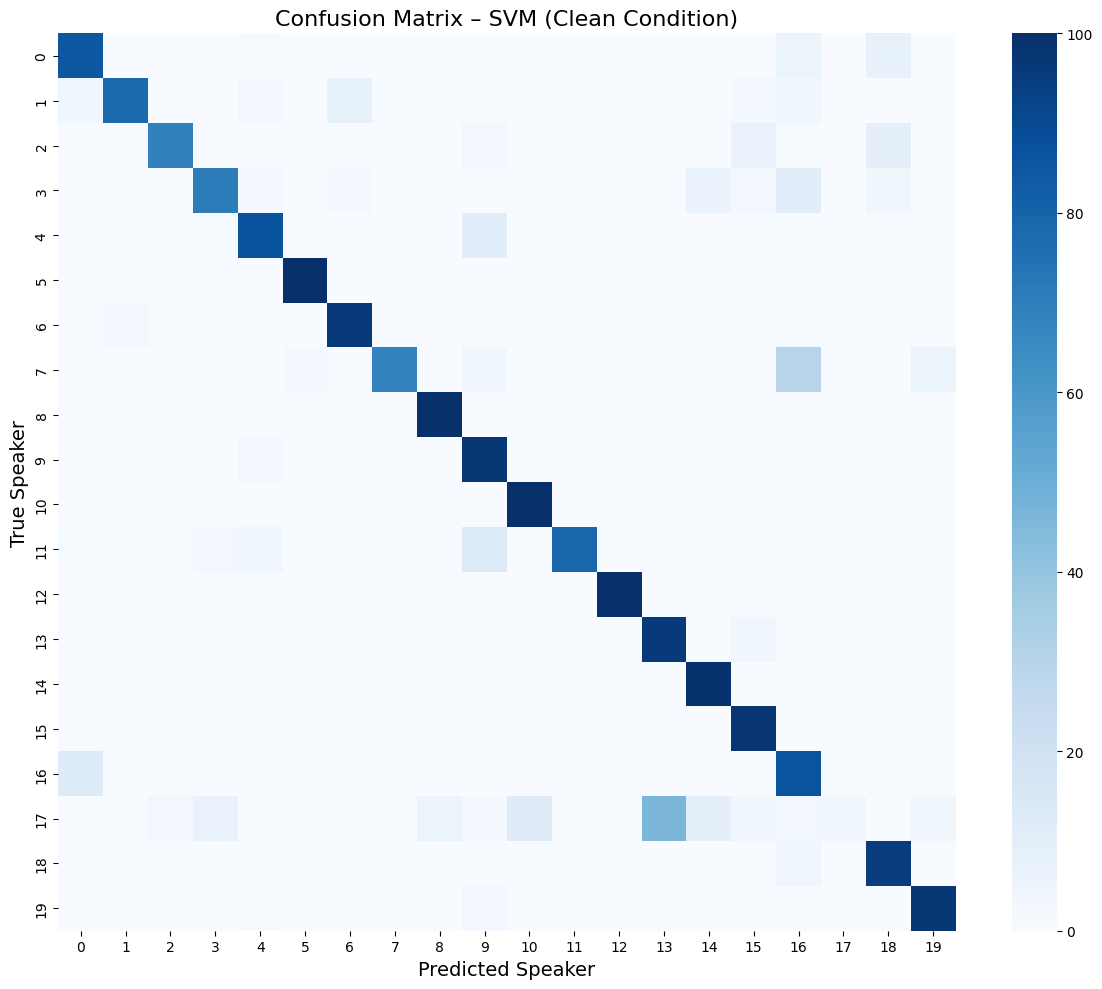

Saved ConfusionMatrix_SVM_Clean.png


In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict with SVM on CLEAN data
y_pred_svm_clean = svm_clf.predict(X_clean)
cm_svm_clean = confusion_matrix(y_clean_enc, y_pred_svm_clean)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_svm_clean,
    cmap="Blues",
    annot=False,
    xticklabels=np.arange(len(np.unique(y_clean))),
    yticklabels=np.arange(len(np.unique(y_clean)))
)

plt.title("Confusion Matrix – SVM (Clean Condition)", fontsize=16)
plt.xlabel("Predicted Speaker", fontsize=14)
plt.ylabel("True Speaker", fontsize=14)
plt.tight_layout()

plt.savefig("ConfusionMatrix_SVM_Clean.png", dpi=300)
plt.show()

print("Saved ConfusionMatrix_SVM_Clean.png")


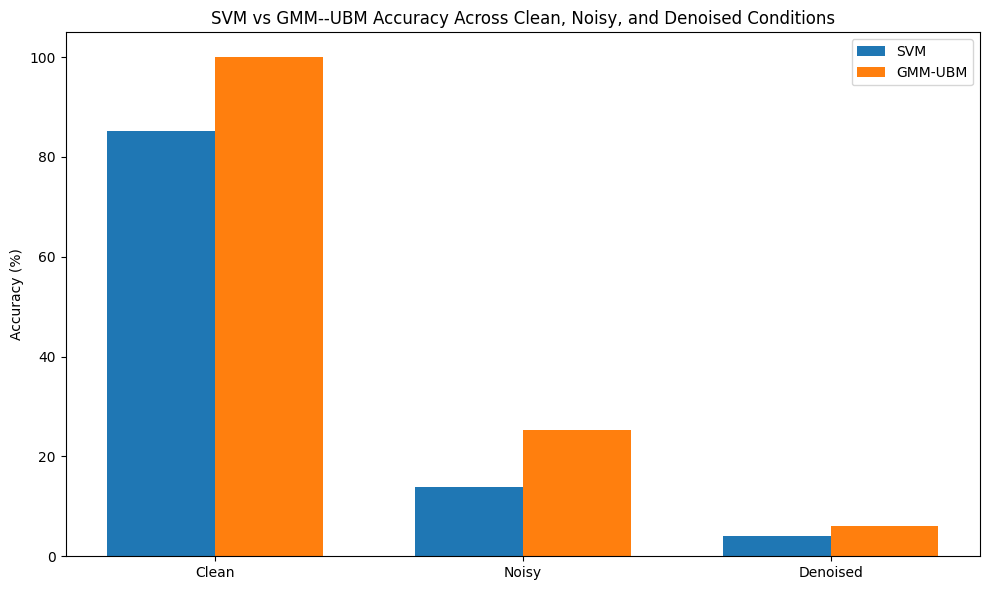

Saved SVM_vs_GMMUBM_Accuracy.png


In [139]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy values (already computed)
conditions = ["Clean", "Noisy", "Denoised"]
svm_vals = [acc_svm_clean*100, acc_svm_noisy*100, acc_svm_denoised*100]
gmm_vals = [acc_gmmubm_clean*100, acc_gmmubm_noisy*100, acc_gmmubm_denoised*100]

x = np.arange(len(conditions))
width = 0.35

plt.figure(figsize=(10, 6))

plt.bar(x - width/2, svm_vals, width, label="SVM")
plt.bar(x + width/2, gmm_vals, width, label="GMM-UBM")

plt.xticks(x, conditions)
plt.ylabel("Accuracy (%)")
plt.title("SVM vs GMM--UBM Accuracy Across Clean, Noisy, and Denoised Conditions")
plt.legend()
plt.tight_layout()

plt.savefig("SVM_vs_GMMUBM_Accuracy.png", dpi=300)
plt.show()

print("Saved SVM_vs_GMMUBM_Accuracy.png")


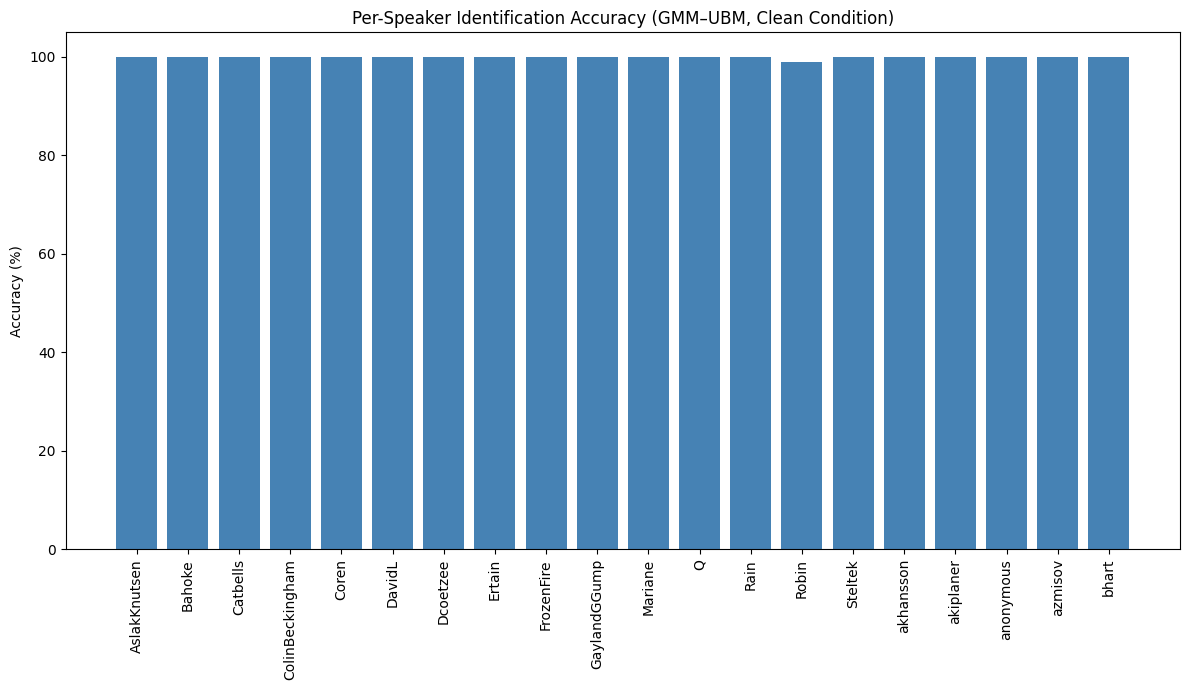

Saved: GMMUBM_PerSpeaker_Accuracy_Clean.png


In [143]:
# -------------------------------------------------------------
# Per-Speaker Accuracy Bar Chart for GMM–UBM (Clean Condition)
# Saves: GMMUBM_PerSpeaker_Accuracy_Clean.png
# -------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Compute per-speaker accuracy
labels = np.unique(y_clean)
speaker_acc = []

for spk in labels:
    idx = np.where(y_clean == spk)[0]
    acc = accuracy_score(y_clean[idx], gmmubm_pred_clean[idx])
    speaker_acc.append(acc * 100)

# Plot
plt.figure(figsize=(12, 7))
plt.bar(labels, speaker_acc, color="steelblue")
plt.xticks(rotation=90)
plt.ylabel("Accuracy (%)")
plt.title("Per-Speaker Identification Accuracy (GMM–UBM, Clean Condition)")
plt.tight_layout()

plt.savefig("GMMUBM_PerSpeaker_Accuracy_Clean.png", dpi=300)
plt.show()

print("Saved: GMMUBM_PerSpeaker_Accuracy_Clean.png")
